In [66]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [108]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=282
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147

In [109]:
# Data Preparation
import pandas as pd
# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_n&f.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_n&f.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [110]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [111]:
print(irows,orows)

3 1


In [112]:
#Fixing number of clusters:
nclust=4

#Selecting correlated time bins based on cluster number
if nclust==4:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_4branch.csv',header =None)
if nclust==3:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_3branch.csv',header =None)
if nclust==2:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/STcor_Tree_2branch.csv',header =None)
index_ps=df_clust[1]

#Creating a list of start time to consider for each model
st2consider=[]
for i in range(nclust):
    st2consider.append([])

#Appending values to cols2consider
for i in range(1,len(index_ps)):
    bloc=int(index_ps[i])
    st2consider[bloc-1].append(i)
    
# Note: Here, in elements of cols2consider, time bins start from 1 and go till 18.
# but while indexing in dataset, it should start from 0 therefore we subtract 1 
# from elements in cols2consider
c2c_copy=st2consider
st2consider=[]
for ar in c2c_copy:
    st2consider.append([k-1 for k in ar])

if st2consider[0]==[k-1 for k in c2c_copy[0]]:
    print("Unit Subraction from st2consider complete! \n")
else:
    print("ERROR: Something wrong with subraction! \n")

#Check if everything is fine
index_l=index_ps.tolist()      # converting pandas series to list
if index_l.count('1')==len(st2consider[0]) and (len(st2consider[nclust-1])==index_l.count(str(nclust))):
    print("Good to go! st2consider seems good..")

Unit Subraction from st2consider complete! 

Good to go! st2consider seems good..


In [113]:
print(st2consider)

[[0, 1, 16], [2, 17], [3, 5, 12, 13, 15], [4, 6, 7, 8, 9, 10, 11, 14]]


In [114]:
# Tutorial or recap:
# The last index is excluded therefore to select 1-18(inclusive) we have to do 1-19
a=[0,1,2,3,4,5,6,7,8,9,10]
print(a[1:4],a[4:7])

[1, 2, 3] [4, 5, 6]


In [115]:
#Tutorial lession for Python0
#df2[:][] # indicates 1st[actaully 2nd] col 2nd[actually 3rd] row
#df2.iloc[0]

In [116]:
# Data from R is same for any bin size.
tdmax=22.8
tdmin=4.066667
def normed2normal(time):
    timo=time*(tdmax - tdmin)+tdmin
    return timo
# Working beautifully for given Min and max time.
#normed2normal(day_df[281])

In [117]:
#Defining a list to put sequences in
sequences_by_grp=[]
for grp in range(nclust):
    sequences_by_grp.append([])

#Define the rows per day
rows_pd=int((et-st)/Bin_size)

#For each day travel times in df2
for day in range(1,int((len(df2)-1)/rows_pd+1)):
    strt_row=day*rows_pd-17
    end_row=strt_row+rows_pd
    #print("The rows are:",strt_row,end_row)
    day_df=(df2.iloc[strt_row:end_row])
    #For each group according to clustered start times
    for grp in range(nclust):
        #print(st2consider[grp])
        #Creating a list for adding numpy arrays of seg tt for st in the group
        tt_group=[]
        #For each element in the group
        for start_t in st2consider[grp]:
            #print("Start:",st+4,"End:",st+5)
            #Selecting the entry with denormalized st within the range
            selected_df=day_df.loc[(normed2normal(day_df[281]) >= start_t+4) & (normed2normal(day_df[281]) <= start_t+5)]
            #Taking mean in case multiple values are present
            pdseries=selected_df.mean()
            #Converting those into a numpy array and putting it in tt_group
            tt_group.append(pdseries.as_matrix())
            #Works good don't touch
        #Appending the matrix to the marticular group
        sequences_by_grp[grp].append(tt_group)
if len(sequences_by_grp)==nclust and len(sequences_by_grp[0])==34 and len(sequences_by_grp[0][0])==3:
    print("Creation of sequences good!")
else:
    print("ERROR: Creation of sequences lengths arent as expected")

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Creation of sequences good!


In [118]:
# Function to check a X,y pair and look at the lengths:
# Not yet prepared for Model-4
def verify_io(Xi,yi,info,i):
    if info==True:
        print("Number of X Tensors:",len(Xi))
        print("Number of y Tensors:",len(yi))
        print("Number i/o pairs expected:",(34-irows-orows+1))
    elif(len(Xi)==len(yi)==(34-irows-orows+1)):
        print("Number of i/o pairs is as expected!")
    else:
        print("ERROR: Number of i/o pairs is not as expected!")
    if info==True:
        print("Shape of X Tensor:",Xi.shape)
        print("Shape of Y Tensor:",yi.shape)
        print("Number of features expected:",len(cols2consider[i])+2,"for X")
    elif(len(Xi[0][1])-2==len(yi[0])==len(cols2consider[i])):
        print("Number of features is as expected!")
    else:
        print("ERROR: Number of features is not as expected!")
#ALways use info = True as false is not incorporated properly

In [119]:
import numpy as np
#Split sequences according to group number given:
def split_sequences_by_grp(sequences, n_steps_in, n_steps_out,grp_no): # Grp no should start from 0
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # Gather input and output parts of the pattern
        print
        seq_x =sequences[i:end_ix,:]
        seq_y = sequences[end_ix:out_end_ix,:,:-2][0]
        Xl[grp_no].append(seq_x)
        yl[grp_no].append(seq_y)
    # Change th +2 below incase the number of inputs and outputs is changed
    #first[0] indicates 1st day of the 3 day input. next[0] indicates 1st start time in grp
    if len(seq_x[0][0])!= len(seq_y[0])+2:
        print("ERROR: column selection wrong!")
    return None

In [120]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Create a list of X and y to put in X and y for different groups.
yl=[]
for i in range(nclust):
    yl.append([])
Xl=[]
for i in range(nclust):
    Xl.append([])
    

n_days_in, n_days_out = 3, 1

#Generate IO Matrices
for grp in range(nclust):
    split_sequences_by_grp(np.asarray(sequences_by_grp[grp]), n_days_in, n_days_out,grp)

# for i in range(1,35):
#     todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
#     for j in range(nclust):
#         split_sequences_by_grp(todays_df, n_steps_in, n_steps_out,j)

# #Check if the matrix are created properly:
# verify_io(Xl[0],yl[0],False,0)
# verify_io(Xl[1],yl[1],True,1)
# verify_io(Xl[2],yl[2],False,2)
# verify_io(Xl[3],yl[3],False,3)
#Pending verification

In [121]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np

# #Function to check if all the NA matrices are deleted.
def check_NA(X_fil,y_fil,Name):
    Na_count=0
    for i in range(len(X_fil)):
        if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
            Na_count=Na_count+1
    if Na_count==0:
        print("Na Matrices filtered out sucessfuly in",Name,"!")
    else:
        print("ERROR: NA value found!")
        
#Function to filter the NA matrices.
def filter_NA(X_o,y_o):
    X_fil=np.array(X_o)
    y_fil=np.array(y_o)
    del_index=[]
    # Noting down the index of Na matrices in del_index 
    for i in range(len(X_fil)):
        del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))
    # Filtering out the Na matrices from y_fil and X_fil by indexing using a list
    y_fil=y_fil[list(~np.array(del_index))]
    X_fil=X_fil[list(~np.array(del_index))]
    return X_fil,y_fil


X1,y1=filter_NA(Xl[0],yl[0])
X2,y2=filter_NA(Xl[1],yl[1])
X3,y3=filter_NA(Xl[2],yl[2])
X4,y4=filter_NA(Xl[3],yl[3])

check_NA(X1,y1,"G1")
check_NA(X2,y2,"G2")
check_NA(X3,y3,"G3")
check_NA(X4,y4,"G4")

Na Matrices filtered out sucessfuly in G1 !
Na Matrices filtered out sucessfuly in G2 !
Na Matrices filtered out sucessfuly in G3 !
Na Matrices filtered out sucessfuly in G4 !


In [122]:
# Print number of IO Pairs available:
print(len(y2)," I/O pairs available")
#verify_io(X1,y1,True,0)

31  I/O pairs available


In [123]:
# Function to Flatten output
#verify_io(Xl[0],yl[0],True,0)

# Note: No need to flatten output as y already has only 2 dimensions.
y1.shape
# def Flatten_output(y_il):
#     n_output = y_il.shape[1] * y_il.shape[2]
#     return y_il.reshape((y_il.shape[0], n_output))

# print(y1)
# y1=Flatten_output(y1)
# y2=Flatten_output(y2)
# y3=Flatten_output(y3)
# y4=Flatten_output(y4)

(31, 3, 280)

In [124]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [125]:
#Reshape input and output
print("Shape of X1:",X1.shape)
print("Shape of X2:",X2.shape)
print("Shape of X3:",X3.shape)
print("Shape of X4:",X4.shape)
print("Shape of y1:",y1.shape)
print("Shape of y2:",y2.shape)
print("Shape of y3:",y3.shape)
print("Shape of y4:",y4.shape)
reshaped_X1=X1.reshape(34-irows-orows+1,X1.shape[2]*X1.shape[1],282)
reshaped_y1=y1.reshape(34-irows-orows+1,280*y1.shape[1])
reshaped_X2=X2.reshape(34-irows-orows+1,X2.shape[2]*X2.shape[1],282)
reshaped_y2=y2.reshape(34-irows-orows+1,280*y2.shape[1])
reshaped_X3=X3.reshape(34-irows-orows+1,X3.shape[2]*X3.shape[1],282)
reshaped_y3=y3.reshape(34-irows-orows+1,280*y3.shape[1])
reshaped_X4=X4.reshape(34-irows-orows+1,X4.shape[2]*X4.shape[1],282)
reshaped_y4=y4.reshape(34-irows-orows+1,280*y4.shape[1])
reshaped_y1.shape,reshaped_X1.shape


Shape of X1: (31, 3, 3, 282)
Shape of X2: (31, 3, 2, 282)
Shape of X3: (31, 3, 5, 282)
Shape of X4: (31, 3, 8, 282)
Shape of y1: (31, 3, 280)
Shape of y2: (31, 2, 280)
Shape of y3: (31, 5, 280)
Shape of y4: (31, 8, 280)


((31, 840), (31, 9, 282))

In [126]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(reshaped_X1)) < 0.8
X_train = reshaped_X1[msk]
y_train = reshaped_y1[msk]
X_test = reshaped_X1[~msk]
y_test = reshaped_y1[~msk]
print("Dataset splitting done! for Grp-1")

#Giving the number of rows and columns in input and output
in_rows=reshaped_X1.shape[1]
in_cols=reshaped_X1.shape[2]
on_cols=reshaped_y1.shape[1]

# multivariate output multi-step 1d cnn example

# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(in_rows, in_cols)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500, activation='relu'))
model1.add(Dense(on_cols))
model1.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model1.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-1 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input days:",n_days_in)
print("Number of output days:",n_days_out)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model1.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model1.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model1.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-1
Group-1 ; Model-3 

Number or epochs: 12
Number of input days: 3
Number of output days: 1
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 24
Number of I/O pairs available for testing: 7
7/7 [==============================] - 0s 255us/step
Model Mape loss: 11523861.0
7/7 [==============================] - 0s 249us/step
Model MSE loss (Minimized): 0.062239233404397964
7/7 [==============================] - 0s 333us/step
RMSE loss: 0.24947792167724575


In [127]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(reshaped_X2)) < 0.8
X_train = reshaped_X2[msk]
y_train = reshaped_y2[msk]
X_test = reshaped_X2[~msk]
y_test = reshaped_y2[~msk]
print("Dataset splitting done! for Grp-2")

#Giving the number of rows and columns in input and output
in_rows=reshaped_X2.shape[1]
in_cols=reshaped_X2.shape[2]
on_cols=reshaped_y2.shape[1]

# multivariate output multi-step 1d cnn example

# define model
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(in_rows, in_cols)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(on_cols))
model2.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model2.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-2 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input days:",n_days_in)
print("Number of output days:",n_days_out)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model2.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model2.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model2.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-2
Group-2 ; Model-3 

Number or epochs: 12
Number of input days: 3
Number of output days: 1
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 24
Number of I/O pairs available for testing: 7
7/7 [==============================] - 0s 199us/step
Model Mape loss: 6787147.5
7/7 [==============================] - 0s 226us/step
Model MSE loss (Minimized): 0.033843789249658585
7/7 [==============================] - 0s 320us/step
RMSE loss: 0.18396681562080316


In [128]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(reshaped_X3)) < 0.8
X_train = reshaped_X3[msk]
y_train = reshaped_y3[msk]
X_test = reshaped_X3[~msk]
y_test = reshaped_y3[~msk]
print("Dataset splitting done! for Grp-3")

#Giving the number of rows and columns in input and output
in_rows=reshaped_X3.shape[1]
in_cols=reshaped_X3.shape[2]
on_cols=reshaped_y3.shape[1]

# multivariate output multi-step 1d cnn example

# define model
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(in_rows, in_cols)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(on_cols))
model3.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model3.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-3 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input days:",n_days_in)
print("Number of output days:",n_days_out)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model3.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model3.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model3.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-3
Group-3 ; Model-3 

Number or epochs: 12
Number of input days: 3
Number of output days: 1
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 24
Number of I/O pairs available for testing: 7
7/7 [==============================] - 0s 644us/step
Model Mape loss: 2072115.375
7/7 [==============================] - 0s 350us/step
Model MSE loss (Minimized): 0.05359527841210365
7/7 [==============================] - 0s 506us/step
RMSE loss: 0.23150654075447555


In [129]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(reshaped_X4)) < 0.8
X_train = reshaped_X4[msk]
y_train = reshaped_y4[msk]
X_test = reshaped_X4[~msk]
y_test = reshaped_y4[~msk]
print("Dataset splitting done! for Grp-4")

#Giving the number of rows and columns in input and output
in_rows=reshaped_X4.shape[1]
in_cols=reshaped_X4.shape[2]
on_cols=reshaped_y4.shape[1]

print(in_rows,in_cols,on_cols)
# multivariate output multi-step 1d cnn example

# define model
model4 = Sequential()
model4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(in_rows, in_cols)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(500, activation='relu'))
model4.add(Dense(on_cols))
model4.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model4.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-4 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input days:",n_days_in)
print("Number of output days:",n_days_out)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model4.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model4.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model4.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-4
24 282 2240
Group-4 ; Model-3 

Number or epochs: 12
Number of input days: 3
Number of output days: 1
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 24
Number of I/O pairs available for testing: 7
7/7 [==============================] - 0s 375us/step
Model Mape loss: 2359397.5
7/7 [==============================] - 0s 650us/step
Model MSE loss (Minimized): 0.046973373740911484
7/7 [==============================] - 0s 826us/step
RMSE loss: 0.21673341629963636


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


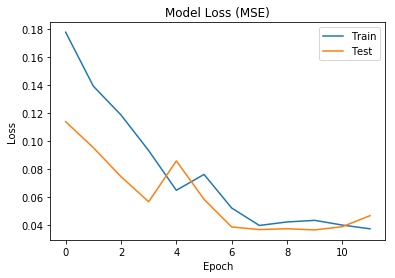

In [130]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [139]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax.csv')

#Functions to calculate error
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [198]:
Minmax

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281
0,144.393008,115.714823,42.493365,24.211194,20.792030,31.301400,15.261249,11.463829,10.438957,10.160103,...,14.777967,13.615912,14.194309,13.784148,15.715016,15.611628,16.334124,23.636502,32.203997,NaN
1,21.743496,27.824041,12.590967,10.181975,9.777823,10.144633,8.673208,7.440940,6.730975,6.393548,...,6.273787,6.223952,6.223956,6.212245,6.268387,6.356335,6.478718,6.811262,7.332060,NaN


In [226]:
import matplotlib.pyplot as plt
import numpy
np.random.seed(95)
msk = np.random.rand(len(reshaped_X4)) < 0.8
X_train = reshaped_X4[msk]
y_train = reshaped_y4[msk]
X_test = reshaped_X4[~msk]
y_test = reshaped_y4[~msk]

#Function to denormalize output 
def denormalize_output(y_list):
    #Correcting with scaling pdt and act 
    #print("length of y-list:",len(y_list))
    y_cor=[i for i in range(len(y_list))]
    for tt_no in range(len(y_list)):
        segno=tt_no%280
        mn=Minmax.iat[0,segno]
        mx=Minmax.iat[1,segno]
        y_cor[tt_no]=(y_list[tt_no]*(mx - mn))+mn
    return y_cor

def get_accuracy(X_val,y_val,model):
    print("X Shape",X_val.shape)
    print("Y Shape",y_val.shape)
    MSE_list=[]
    RMSE_list=[]
    MAPE_list=[]
    for io in range(len(X_val)):
        #Choose a random sample and and get prediction and actual value
        x_input = X_val[io]
        x_input = x_input.reshape((1, x_input.shape[0], x_input.shape[1]))
        yhat = model.predict(x_input, verbose=0)
        y_output = y_test[io]
        pdt=yhat[0]
        act=y_output
        pdt_cor=denormalize_output(pdt)
        act_cor=denormalize_output(act)
        if len(pdt_cor)!=len(act_cor):
            print("ERROR")
        MSE_list.append(mean_squared_error(act_cor,pdt_cor))
        RMSE_list.append(np.sqrt(mean_squared_error(act_cor,pdt_cor)))
        MAPE_list.append(mean_absolute_percentage_error(act_cor,pdt_cor))
    print("MSE:",sum(MSE_list)/len(MSE_list))
    print("RMSE:",sum(RMSE_list)/len(RMSE_list))
    print("MAPE:",sum(MAPE_list)/len(MAPE_list))
get_accuracy(X_test,y_test,model4)

X Shape (7, 24, 282)
Y Shape (7, 2240)
MSE: 52.565866161648344
RMSE: 7.213883055216792
MAPE: 14.499855216295334


length of y-list: 2240
length of y-list: 2240
pdt length: 2240
act length: 2240


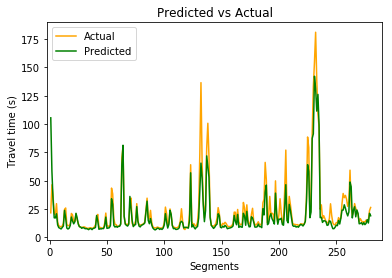

In [207]:
# plot travel time actual vs predicted
x_input = X_test[1]
x_input = x_input.reshape((1, x_input.shape[0], x_input.shape[1]))
yhat = model4.predict(x_input, verbose=0)
y_output = y_test[1]
pdt=yhat[0]
act=y_output

print("pdt length:",len(pdt))
print("act length:",len(act))
#Plot the data: 
x=list(range(1,281))
plt.plot(x, act_cor[0:280], color='orange',label="Actual")
plt.plot(x, pdt_cor[0:280], color='g',label="Predicted")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,280+10])
leg = plt.legend();
plt.show()